In [115]:
import pandas as pd
import numpy as np
import plotly.express as px

import matplotlib.pyplot as plt
import wordcloud
import numpy as np
import io
import requests
import PIL
import matplotlib.pyplot as plt
from random import sample 
from collections import Counter

from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

import nltk 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

img = "https://raw.githubusercontent.com/linogaliana/python-datascientist/master/content/modelisation/7_nlp/book.png"
book_mask = np.array(PIL.Image.open(io.BytesIO(requests.get(img).content)))

# Option d'affchage
pd.set_option('display.max_columns', None)

In [58]:
# Importation de la base nettoyée

df0 = pd.read_csv('data/data_cleaned.csv', sep = ',', encoding='latin-1')

In [59]:
df = df0[[
        'Orateur', 'Unnamed: 0', 'Sujet.débattu', 'Réplique', 
        'Didascalie', 'commissions', 'Groupe', 'tokenized_replique', 
        'stemmed_replique', 'tokenized_didascalie', 'stemmed_didascalie'
        ]]

df = df.rename(columns = {
                            'Unnamed: 0': 'index'
                         }
              )

In [60]:
# Gestion des nan

df['tokenized_replique'] = df['tokenized_replique'].fillna('')
df['stemmed_replique'] = df['stemmed_replique'].fillna('')
df['tokenized_didascalie'] = df['tokenized_didascalie'].fillna('')
df['stemmed_didascalie'] = df['stemmed_didascalie'].fillna('')

### Fréquence relative des novices en nombre d’intervention et nombre de mots total

In [61]:
nb_nov = df[df['Groupe'] == 'Novice'].drop_duplicates(subset = ['Orateur'], keep = 'first').shape[0]
nb_intervention_nov  = df[df['Groupe'] == 'Novice'].shape[0]
score_nov = int(10 * nb_intervention_nov / nb_nov) / 10 

nb_exp = df[df['Groupe'] == 'Exp'].drop_duplicates(subset = ['Orateur'], keep = 'first').shape[0]
nb_intervention_exp  = df[df['Groupe'] == 'Exp'].shape[0]
score_exp = int(10 * nb_intervention_exp / nb_exp) / 10

ratio = int(10 * score_exp / score_nov) / 10

In [62]:
print('Nombre moyen de réplique par intervenant pour un Novice: ' + str(score_nov))
print('Nombre moyen de réplique par intervenant pour un Non-Novice: ' + str(score_exp))

print('Ratio : ', ratio)

Nombre moyen de réplique par intervenant pour un Novice: 460.8
Nombre moyen de réplique par intervenant pour un Non-Novice: 1021.8
Ratio :  2.2


Les non-novices parlent clairement plus que les novices : plus de 2 fois plus

#### Construction de la variable du nombre d'intervention par orateur

In [63]:
orateurs = list(set(df['Orateur']))
comptes = []

for orateur in orateurs:
    nombre_intervention = df[df['Orateur'] == orateur].shape[0]
    comptes.append((orateur, nombre_intervention))

comptes = dict(comptes)

In [64]:
df['nb_interventions'] = df.apply(lambda row: comptes[row.Orateur], axis = 1)

#### Répartition du nombre d'interventions au sein de chaque groupe

Pour les novices : 

In [65]:
px.histogram(df[df['Groupe'] == 'Novice'].drop_duplicates(subset = ['Orateur'], keep = 'first').sort_values(by = 'nb_interventions'), x = 'Orateur', y = 'nb_interventions')

Pour les non-novices : 

In [66]:
px.histogram(df[df['Groupe'] == 'Exp'].drop_duplicates(subset = ['Orateur'], keep = 'first').sort_values(by = 'nb_interventions'), x = 'Orateur', y = 'nb_interventions')

On note qu'il y a deux orateurs non-novices (R. Ferrand et F. De Rugy) qui dominent très largement le nombre d'intervention dans leur groupe. Ches les novices, il n'y a pas de telle domination.

#### Construction de la variable du nombre de mot par intervention

In [67]:
df['nb_mots'] = df.apply(lambda row: len(row.Réplique.split(' ')), axis = 1)

In [68]:
nb_mot_nov = df[df['Groupe'] == 'Novice'][['nb_mots']].sum()
score_nov = int(10 * nb_mot_nov / nb_intervention_nov) / 10 

nb_mot_exp = df[df['Groupe'] == 'Exp'][['nb_mots']].sum()
score_exp = int(10 * nb_mot_exp / nb_intervention_exp) / 10 

ratio = int(10 * score_exp / score_nov) / 10

In [69]:
print('Nombre moyen de mots par intervention pour un Novice: ' + str(score_nov))
print('Nombre moyen de mots par intervention pour un Non-Novice: ' + str(score_exp))

print('Ratio : ', ratio)

Nombre moyen de mots par intervention pour un Novice: 51.5
Nombre moyen de mots par intervention pour un Non-Novice: 46.0
Ratio :  0.8


On remarque que les interventions des novices et non-novices sont à peu près de la même longueur (légèrement plus long pour les novices).

### Analyse des didascalies

On créé pour chaque réplique les variables binaires suivantes :  
    -présence de didascalies  
    -présence de didascalies positives (applaudissement, exclamation)  
    -présence de didascalies négative 

In [70]:
# On définit d'abord les mots qui caractérisent une didascalie positive ou negative

positive_words = ['applaud', 'oui']

negative_words = ['exclam', 'protest', 'quitt', 'murmur']

def positivite_didascalie(stemmed_didascalie):
    text = str(stemmed_didascalie).split(' ')
    
    if len(text) == 0:
        return 0
    
    for word in positive_words:
        if word in text:
            return 1
    
    for word in negative_words:
        if word in text:
            return -1
        
    return 0

In [71]:
df['presence_didascalie'] = df.apply(lambda row: int(str(row.stemmed_didascalie) != ''), axis = 1)

df['didascalie_positive'] = df.apply(lambda row: int(positivite_didascalie(row.stemmed_didascalie) == 1), axis = 1)
df['didascalie_negative'] = df.apply(lambda row: int(positivite_didascalie(row.stemmed_didascalie) == -1), axis = 1)

Calcul de la fréquence de didascalie, de didascalie positive, et de didascalie négative dans chaque groupe. 

In [72]:
# Pour les non-novices

nb_didasc_nov = df[df['Groupe'] == 'Novice'][['presence_didascalie']].sum()
score0_nov = int(1000 * nb_didasc_nov / nb_intervention_nov) / 1000

nb_didasc_postitive_nov = df[df['Groupe'] == 'Novice'][['didascalie_positive']].sum()
score1_nov = int(1000 * nb_didasc_postitive_nov / nb_intervention_nov) / 1000

nb_didasc_negative_nov = df[df['Groupe'] == 'Novice'][['didascalie_negative']].sum()
score2_nov = int(1000 * nb_didasc_negative_nov / nb_intervention_nov) / 1000 

taux_positivite_negativite_nov = int(1000 * score1_nov / (score1_nov + score2_nov)) / 1000


# Pour les non-novices

nb_didasc_exp = df[df['Groupe'] == 'Exp'][['presence_didascalie']].sum()
score0_exp = int(1000 * nb_didasc_exp / nb_intervention_exp) / 1000

nb_didasc_postitive_exp = df[df['Groupe'] == 'Exp'][['didascalie_positive']].sum()
score1_exp = int(1000 * nb_didasc_postitive_exp / nb_intervention_exp) / 1000 

nb_didasc_negative_exp = df[df['Groupe'] == 'Exp'][['didascalie_negative']].sum()
score2_exp = int(1000 * nb_didasc_negative_exp / nb_intervention_exp) / 1000 

taux_positivite_negativite_exp = int(1000 * score1_exp / (score1_exp + score2_exp)) / 1000

In [73]:
print('Proportion des intervention avec présence de didascalies pour un novice: ' + str(score0_nov))
print('Proportion des intervention avec présence de didascalies positives pour un novice: ' + str(score1_nov))
print('Proportion des intervention avec présence de didascalies négatives pour un novice: ' + str(score2_nov))
print('Ratio de positivité des didascalies pour les novices: ' + str(taux_positivite_negativite_nov) + '\n')



print('Proportion des intervention avec présence de didascalies pour un non-novice: ' + str(score0_exp))
print('Proportion des intervention avec présence de didascalies positives pour un non-novice: ' + str(score1_exp))
print('Proportion des intervention avec présence de didascalies négatives pour un non-novice: ' + str(score2_exp))
print('Ratio de positivité des didascalies pour les non-novices: ' + str(taux_positivite_negativite_exp))

Proportion des intervention avec présence de didascalies pour un novice: 0.101
Proportion des intervention avec présence de didascalies positives pour un novice: 0.07
Proportion des intervention avec présence de didascalies négatives pour un novice: 0.019
Ratio de positivité des didascalies pour les novices: 0.786

Proportion des intervention avec présence de didascalies pour un non-novice: 0.082
Proportion des intervention avec présence de didascalies positives pour un non-novice: 0.057
Proportion des intervention avec présence de didascalies négatives pour un non-novice: 0.012
Ratio de positivité des didascalies pour les non-novices: 0.826


Conclusions :  
    -Les novices suscitent plus de réaction que les non-novices (10% contre 8%)  
    -Les réactions que suscitent les novices sont moins positives que les non-novices. Ils sont plus souvent contéstés.

## Etude de la fréquence des mots

### Worldcloud

On travaille avec les textes tokenizés

In [74]:
# Création des corpus novice et non-novice

corpus_novice = ' '.join(sample(list(df[df['Groupe'] == 'Novice']['tokenized_replique']), 50000))
corpus_exp = ' '.join(sample(list(df[df['Groupe'] == 'Exp']['tokenized_replique']), 50000))

In [75]:
def make_wordcloud(corpus):
    wc = wordcloud.WordCloud(background_color="white", max_words = 15)
    wc.generate(corpus)
    return wc

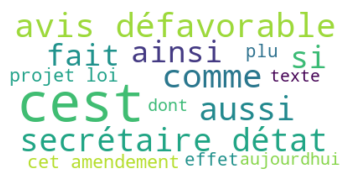

In [76]:
# Pour les novices

wc = make_wordcloud(corpus_novice)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

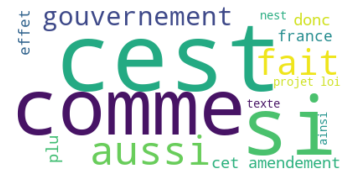

In [77]:
# Pour les non-novices

wc = make_wordcloud(corpus_exp)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

On peut déjà remarquer la présence du mot 'défavorable' qui apparait comme un des mots les plus cités chez les novices et pas chez les non-novices.

#### Classements des mots les plus cités (histogrammes)  

On utilise cette fois les replique avec stemming pour plus de pertinence (mais moins de lisibilité)

In [78]:
# Comptage des mots

count_words = pd.DataFrame({'counter' : df[['Groupe', 'stemmed_replique']]
    .groupby('Groupe')
    .apply(lambda s: ' '.join(s['stemmed_replique']).split())
    .apply(lambda s: Counter(s))
    .apply(lambda s: s.most_common(25))
    .explode()}
)
count_words[['word','count']] = pd.DataFrame(count_words['counter'].tolist(), index=count_words.index)
count_words = count_words.reset_index()

In [79]:
# Classement des mots pour les novices

px.histogram(count_words[count_words['Groupe'] == 'Novice'], x = 'word', y = 'count')

In [80]:
# Classement des mots pour les non-novices

px.histogram(count_words[count_words['Groupe'] == 'Exp'], x = 'word', y = 'count')

Commentaires :  
     -on retrouve toujours beaucoup de mots de liaisons  
     -pour les novices :  
          +  : rapporteur, commission, défavorable, projet    
          -  : ministr(-e, -aire)  
-les novices auraient plus tendance à rappeler le sujet de leur intervention (rapporteur, commission, projet)  
-la présence du mot défavorable est particulièrement intéressante (19ème mot pour les novices, 184ème mot pour les non-novices), nous allons voir comment l'interpréter
            
            
Note : à l'avenir laisser les stopwords pour étudier la "rethorique"

##### Question : quels mots sont le plus associés au mot 'défavorable' dans les deux corpus ?

#### Approche contextuelle avec les bi-gramms

In [81]:
corpus_novice_liste = corpus_novice.split(' ')
text = nltk.Text(corpus_novice_liste)

text.concordance('défavorable')

Displaying 25 of 4822 matches:
ographie profession devenait trop défavorable entre nombre dexploitants agricol
 décret conseil détat rapporteure défavorable plutôt quun rapport inspection pe
lus fragiles rapporteure spéciale défavorable pouvons terminer lexamen crédits 
rapporteur commission a émis avis défavorable cet amendement dont ladoption abo
parcours cest pourquoi donne avis défavorable ainsi républicains déposé amendem
tées malheureusement avis demeure défavorable tout dabord faut confondre missio
ministratives indépendantes lavis défavorable nétait pourtant faute faire preuv
ment parties cours procédure avis défavorable vu but simplification réduction d
objet amendement secrétaire détat défavorable secrétaire détat avis défavorable
défavorable secrétaire détat avis défavorable depuis quarante ans beaucoup dact
commission affaires sociales avis défavorable tiens apporter précision propos a
nt a repoussé commission jy aussi défavorable commissaires lr voté lamendement 
fert ceri

In [82]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

def collocations_word(word):
    
    # Ngrams with a specific name 
    name_filter = lambda *w: word not in w

    finder = BigramCollocationFinder.from_words(text)

    finder.apply_ngram_filter(name_filter)

    return finder.nbest(bigram_measures.likelihood_ratio, 10)

In [83]:
collocations = collocations_word('défavorable')

In [84]:
for colloc in collocations:
    print(colloc, '\n')

('avis', 'défavorable') 

('lavis', 'défavorable') 

('rapporteure', 'défavorable') 

('défavorable', 'rapporteure') 

('donc', 'défavorable') 

('défavorable', 'cet') 

('défavorable', 'amendements') 

('rapporteur', 'défavorable') 

('défavorable', 'rapporteur') 

('défavorable', 'lamendement') 



On parle donc beaucoup d'AVIS défavorables du RAPPORTEUR.

Question avis défavorable sur quoi ?

#### Approche TF-IDF

In [85]:
train = df[df['Groupe'] == 'Novice'][['stemmed_replique']]

In [87]:
tfidf = TfidfVectorizer()
tfs = tfidf.fit_transform(train['stemmed_replique'])

In [88]:
feature_names = tfidf.get_feature_names()
corpus_index = [n for n in list(tfidf.vocabulary_.keys())]
result_df = pd.DataFrame(tfs.todense(), columns = feature_names)

In [89]:
liste_defavor = result_df['défavor'].sort_values(ascending = False).head(n = 30).index.tolist()

In [114]:
# On regarde dans quelles répliques sont les mieux scorées

for i in [train.iloc[[i]].index[0] for i in liste_defavor]:
    print(df.iloc[i]['Réplique'])

 Défavorable.
 rapporteure. Défavorable.
 rapporteur. Défavorable.
 rapporteur. Défavorable.
 rapporteure. Défavorable.
rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Il est défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteur. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable<U+0080>!
 rapporteure. Défavorable.
 rapporteur. Défavorable.
 rapporteur. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
rapporteur. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteur. Défavorable.
 rapporteur. Défavorable.
 rapporteure. Défavorable.
 rapporteur. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteure. Défavorable.
 rapporteur